**Multi-class text classification with Artificial Neural Networks** 

In [11]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from keras import backend as K, utils
from keras.layers import Input, Dense, Flatten, Activation, Dropout, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.backend import clear_session

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# load a clean dataset
def load_data(file_path, header=0, squeeze=False):
  return pd.read_csv(file_path, header=header, squeeze=squeeze)


# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer


# calculate the maximum document length
def max_length(text):
	return max([len(s.split()) for s in text])


# encode a list of textual lines
def encode_text(tokenizer, text, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(text)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded


# fit a one-hot encoder
def create_onehot_encoder(data, columns=['transaction_type', 'transaction_account_type']):
  onehot_encoder = OneHotEncoder()
  transformer = ColumnTransformer([('onehot_encoder',
                                    onehot_encoder,
                                    columns)])
  transformer.fit(data)
  return transformer


# encode categorical columns
def encode_categories(encoder, data):
  return encoder.transform(data)


# encode output data (labels)
def encode_labels(train_y, test_y):
  encoder = LabelEncoder()
  encoder.fit(train_y)
  train_y = encoder.transform(train_y)
  test_y = encoder.transform(test_y)
  num_classes = np.max(train_y) + 1
  train_y = utils.to_categorical(train_y, num_classes)
  test_y = utils.to_categorical(test_y, num_classes)
  classes = list(encoder.classes_)
  return train_y, test_y, classes


# calculate recall metric
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall


# calculate precision metric
def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision


# calculate f1-score metric
def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


# plot metric history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


# predict outputs on test data
def predict(model, inputs, classes):
  return pd.DataFrame(model.predict(inputs), columns=classes)
  

# insert predicted class and confidence for each transaction
# make evidence of possible errors with new column
def get_results(df1, df2):
  df2['transaction_class'] = ""
  df2['confidence'] = np.nan
  # Class with maximum probability is predicted class
  # This probability represents confidence
  for index, row in df1.iterrows():
      df2.loc[index, 'transaction_class'] = row.idxmax()
      df2.loc[index, 'confidence'] = row.max()
      if (row.idxmax() in ['payment', 'transfer', 'cash-withdrawal', 'bank-fee'] and df2.loc[index, 'transaction_type'] == 'credit') or \
          (row.idxmax() in ['interest', 'refund', 'transfer'] and df2.loc[index, 'transaction_type'] == 'debit'): 
          df2.loc[index, 'error'] = 0
      else:
          df2.loc[index, 'error'] = 1
  return df2


# separate textual data and categorical columns
def separate_text_and_categories(data, text, categories):
  text_column = data[text]
  categories_df = data[categories]
  return text_column, categories_df


# merge textual data and categorical columns
def combine_text_and_categories(data, text, categories):
  i = 0
  while i < len(categories):
    data[text] = data[text] + " " + data[categories[i]] 
    i += 1
  return data[text]

**ANN (separated inputs)**

In [3]:
# load training dataset
X_train = load_data('drive/MyDrive/Colab Notebooks/basiq/X_train.csv')
y_train = load_data('drive/MyDrive/Colab Notebooks/basiq/y_train.csv', squeeze=True)

# load validation dataset
X_test = load_data('drive/MyDrive/Colab Notebooks/basiq/X_test.csv')
y_test = load_data('drive/MyDrive/Colab Notebooks/basiq/y_test.csv', squeeze=True)

# load test dataset
scorecard_df = load_data('drive/MyDrive/Colab Notebooks/basiq/scorecard_cleaned.csv')

In [4]:
# get text and categorical columns separated
text_train, categories_train = separate_text_and_categories(X_train, 'description_processed', ['transaction_type', 'transaction_account_type'])
text_test, categories_test = separate_text_and_categories(X_test, 'description_processed', ['transaction_type', 'transaction_account_type'])
text_scorecard, categories_scorecard = separate_text_and_categories(scorecard_df, 'description_processed', ['transaction_type', 'transaction_account_type'])

# make sure all text is string
text_train = text_train.astype(str)
text_test = text_test.astype(str)

# create tokenizer
tokenizer = create_tokenizer(text_train)

# calculate max document length
length = max_length(text_train)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode textual data
text_train = encode_text(tokenizer, text_train, length)
text_test = encode_text(tokenizer, text_test, length)
text_scorecard = encode_text(tokenizer, scorecard_df['description_processed'].astype(str), length)
print(f'Training text size: {text_train.shape}')
print(f'Validation text size: {text_test.shape}')
print(f'Testing text size: {text_scorecard.shape}')

# create onehot encoder
encoder = create_onehot_encoder(categories_train)

# encode categorical data
categories_train = encode_categories(encoder, categories_train)
categories_test = encode_categories(encoder, categories_test)
categories_scorecard = encode_categories(encoder, categories_scorecard)

# encode labels
y_train, y_test, classes = encode_labels(y_train, y_test)

Max document length: 20
Vocabulary size: 18326
Training text size: (80000, 20)
Validation text size: (20000, 20)
Testing text size: (467, 20)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 16)       293216      text_input[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 320)          0           embedding[0][0]                  
__________________________________________________________________________________________________
categories_input (InputLayer)   [(None, 6)]          0                                            
______________________________________________________________________________________________

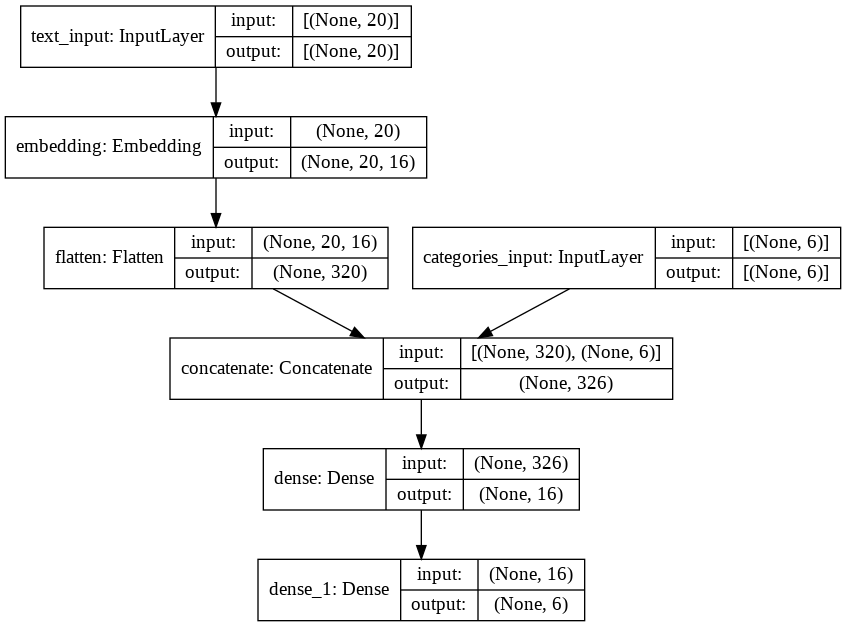

In [5]:
# create model

embedding_size = 16

text_input = Input(shape=(length,), name='text_input')
categories_input = Input(shape=(categories_train.shape[1],), name='categories_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=text_train.shape[1])(text_input)
text_output = Flatten()(emb)
merged = concatenate([text_output, categories_input])
dense1 = Dense(embedding_size, activation='relu')(merged)
outputs = Dense(y_train.shape[1], activation='softmax')(dense1)

model_1 = Model(inputs=[text_input , categories_input], outputs=outputs)

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=f1_m)

# summarize
print(model_1.summary())
plot_model(model_1, show_shapes=True, show_layer_names=True, to_file='drive/MyDrive/Colab Notebooks/basiq/ANN_1.png')

In [6]:
# train model

batch_size = 32
epochs = 15

history_1 = model_1.fit([text_train, categories_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([text_test, categories_test], y_test))

Epoch 1/15
2500/2500 [==============================] - 17s 6ms/step - loss: 0.4427 - f1_m: 0.7924 - val_loss: 0.0172 - val_f1_m: 0.9965
Epoch 2/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0123 - f1_m: 0.9975 - val_loss: 0.0118 - val_f1_m: 0.9977
Epoch 3/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.0068 - f1_m: 0.9984 - val_loss: 0.0100 - val_f1_m: 0.9980
Epoch 4/15
2500/2500 [==============================] - 14s 5ms/step - loss: 0.0038 - f1_m: 0.9990 - val_loss: 0.0118 - val_f1_m: 0.9977
Epoch 5/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.0034 - f1_m: 0.9992 - val_loss: 0.0122 - val_f1_m: 0.9968
Epoch 6/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0028 - f1_m: 0.9992 - val_loss: 0.0110 - val_f1_m: 0.9976
Epoch 7/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.0024 - f1_m: 0.9991 - val_loss: 0.0132 - val_f1_m: 0.9974
Epoch 8/15
2500/2500 [===================

In [7]:
# evaluate model
loss, f1_m = model_1.evaluate([text_train, categories_train] , y_train, verbose=False)
print("Training F1 score: {:.4f}".format(f1_m))
loss, f1_m = model_1.evaluate([text_test, categories_test], y_test, verbose=False)
print("Validation F1 score:  {:.4f}".format(f1_m))

Training F1 score: 0.9995
Validation F1 score:  0.9970


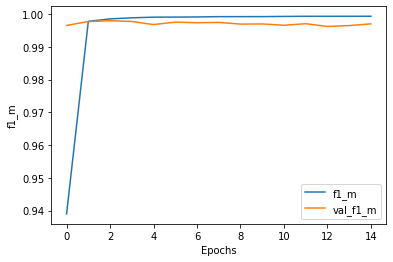

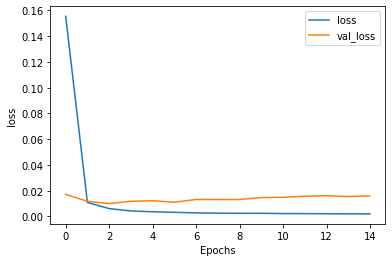

In [8]:
# plot metrics history
plot_graphs(history_1, "f1_m")
plot_graphs(history_1, "loss")

In [9]:
# save model
model_1.save('drive/MyDrive/Colab Notebooks/basiq/ann_1.h5')

In [12]:
# clear session before start to train model again
clear_session()

At the end of the training, we can see that there is a little bit overfitting.

Now we add dropout layers as a method of regularization.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 16)       293216      text_input[0][0]                 
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 320)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
categories_input (InputLayer)   [(None, 6)]          0                                            
____________________________________________________________________________________________

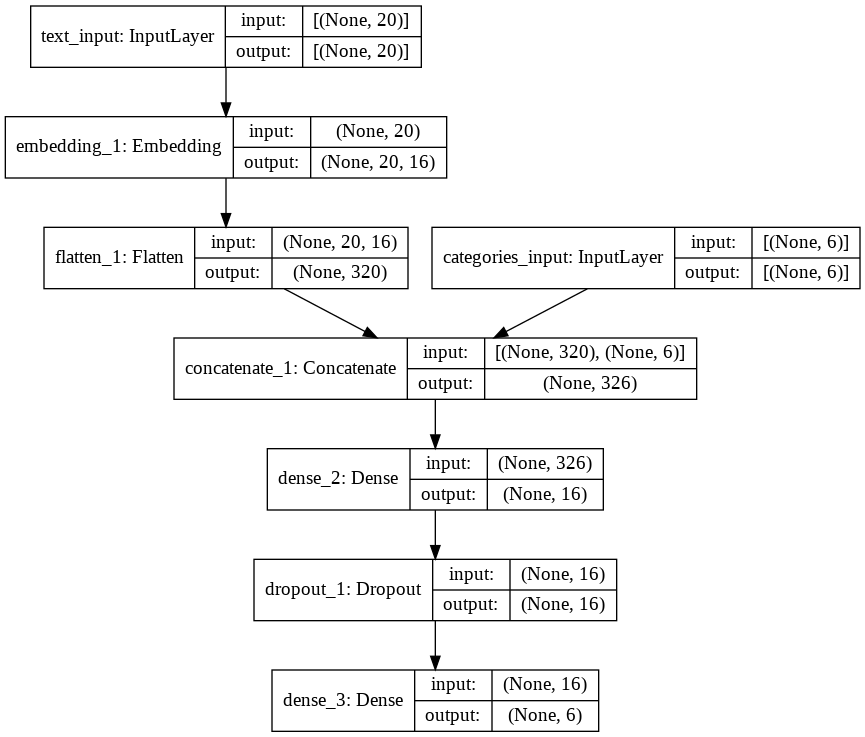

In [16]:
# regularization

# create model

embedding_size = 16

text_input = Input(shape=(length,), name='text_input')
categories_input = Input(shape=(categories_train.shape[1],), name='categories_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=text_train.shape[1])(text_input)
text_output = Flatten()(emb)
merged = concatenate([text_output, categories_input])
dense1 = Dense(embedding_size, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1) 
outputs = Dense(y_train.shape[1], activation='softmax')(dropout1)

model_2 = Model(inputs=[text_input , categories_input], outputs=outputs)

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=f1_m)

# summarize
print(model_2.summary())
plot_model(model_2, show_shapes=True, show_layer_names=True, to_file='drive/MyDrive/Colab Notebooks/basiq/ANN_2.png')

In [17]:
# train model

batch_size = 32
epochs = 15

history_2 = model_2.fit([text_train, categories_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([text_test, categories_test], y_test))

Epoch 1/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.6624 - f1_m: 0.6765 - val_loss: 0.0269 - val_f1_m: 0.9959
Epoch 2/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1365 - f1_m: 0.9536 - val_loss: 0.0177 - val_f1_m: 0.9973
Epoch 3/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1020 - f1_m: 0.9664 - val_loss: 0.0162 - val_f1_m: 0.9979
Epoch 4/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0895 - f1_m: 0.9700 - val_loss: 0.0175 - val_f1_m: 0.9978
Epoch 5/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0812 - f1_m: 0.9740 - val_loss: 0.0193 - val_f1_m: 0.9975
Epoch 6/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0804 - f1_m: 0.9740 - val_loss: 0.0210 - val_f1_m: 0.9978
Epoch 7/15
2500/2500 [==============================] - 16s 6ms/step - loss: 0.0758 - f1_m: 0.9756 - val_loss: 0.0223 - val_f1_m: 0.9979
Epoch 8/15
2500/2500 [===================

In [18]:
# evaluate model

loss, f1_m = model_2.evaluate([text_train, categories_train] , y_train, verbose=False)
print("Training F1 score: {:.4f}".format(f1_m))
loss, f1_m = model_2.evaluate([text_test, categories_test], y_test, verbose=False)
print("Testing F1 score:  {:.4f}".format(f1_m))

Training F1 score: 0.9991
Testing F1 score:  0.9966


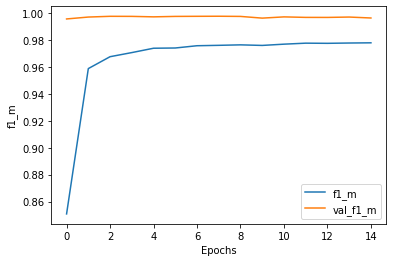

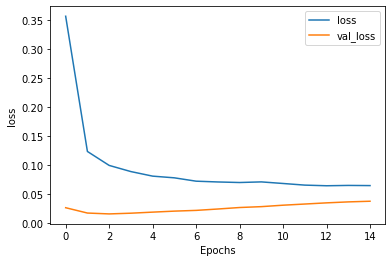

In [19]:
# plot metrics history
plot_graphs(history_2, "f1_m")
plot_graphs(history_2, "loss")

In [21]:
# save model
model_2.save('drive/MyDrive/Colab Notebooks/basiq/ann_2.h5')

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding.


In [22]:
# clear session before start to train model again
clear_session()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 50)       916300      text_input[0][0]                 
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 50)           0           embedding_2[0][0]                
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 50)           0           global_max_pooling1d_2[0][0]     
____________________________________________________________________________________________

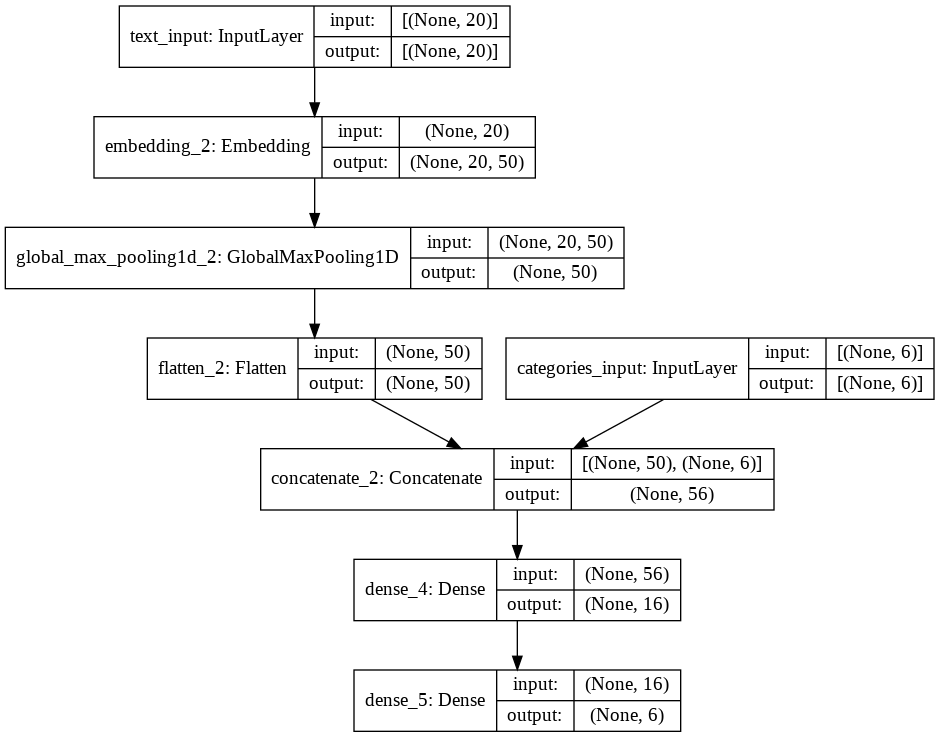

In [27]:
# create model

embedding_size = 50

text_input = Input(shape=(length,), name='text_input')
categories_input = Input(shape=(categories_train.shape[1],), name='categories_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=text_train.shape[1])(text_input)
pool1 = GlobalMaxPool1D()(emb)
text_output = Flatten()(pool1)
merged = concatenate([text_output, categories_input])
# interpretation
dense1 = Dense(16, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1) 
outputs = Dense(y_train.shape[1], activation='softmax')(dense1)

model_3 = Model(inputs=[text_input , categories_input], outputs=outputs)

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=f1_m)

# summarize
print(model_3.summary())
plot_model(model_3, show_shapes=True, show_layer_names=True, to_file='drive/MyDrive/Colab Notebooks/basiq/ANN_3.png')

In [28]:
# train model

batch_size = 32
epochs = 15

history_3 = model_3.fit([text_train, categories_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([text_test, categories_test], y_test))

Epoch 1/15
2500/2500 [==============================] - 34s 13ms/step - loss: 0.4520 - f1_m: 0.7670 - val_loss: 0.0133 - val_f1_m: 0.9970
Epoch 2/15
2500/2500 [==============================] - 31s 13ms/step - loss: 0.0092 - f1_m: 0.9982 - val_loss: 0.0095 - val_f1_m: 0.9977
Epoch 3/15
2500/2500 [==============================] - 31s 12ms/step - loss: 0.0073 - f1_m: 0.9985 - val_loss: 0.0083 - val_f1_m: 0.9983
Epoch 4/15
2500/2500 [==============================] - 34s 13ms/step - loss: 0.0043 - f1_m: 0.9990 - val_loss: 0.0098 - val_f1_m: 0.9979
Epoch 5/15
2500/2500 [==============================] - 35s 14ms/step - loss: 0.0033 - f1_m: 0.9992 - val_loss: 0.0102 - val_f1_m: 0.9979
Epoch 6/15
2500/2500 [==============================] - 31s 12ms/step - loss: 0.0026 - f1_m: 0.9992 - val_loss: 0.0097 - val_f1_m: 0.9981
Epoch 7/15
2500/2500 [==============================] - 32s 13ms/step - loss: 0.0026 - f1_m: 0.9991 - val_loss: 0.0108 - val_f1_m: 0.9979
Epoch 8/15
2500/2500 [============

In [29]:
# evaluate model
loss, f1_m = model_3.evaluate([text_train, categories_train] , y_train, verbose=False)
print("Training F1 score: {:.4f}".format(f1_m))
loss, f1_m = model_3.evaluate([text_test, categories_test], y_test, verbose=False)
print("Testing F1 score:  {:.4f}".format(f1_m))

Training F1 score: 0.9995
Testing F1 score:  0.9969


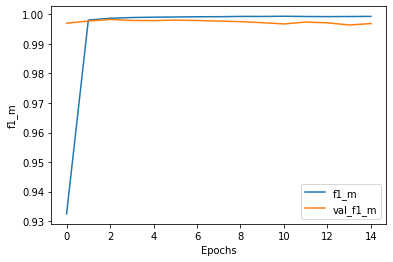

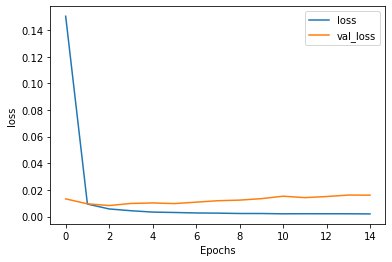

In [30]:
# plot metrics history
plot_graphs(history_3, "f1_m")
plot_graphs(history_3, "loss")

In [31]:
# save model
model_3.save('drive/MyDrive/Colab Notebooks/basiq/ann_3.h5')

In [32]:
# clear session before start to train model again
clear_session()

Final model is with two dropout layers. One dropout layer after maxpooling and another before output layer. Also smaller number of epochs and and larger batch size is used to prevent overfitting.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 50)       916300      text_input[0][0]                 
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 50)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50)           0           global_max_pooling1d_1[0][0]     
____________________________________________________________________________________________

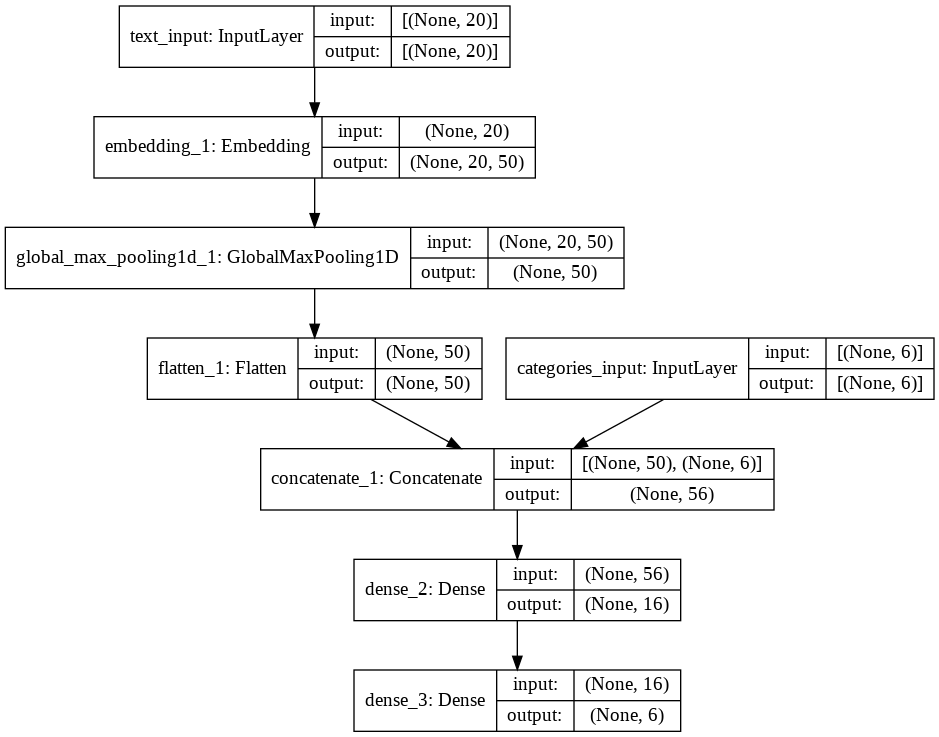

In [36]:
# create model

embedding_size = 50

text_input = Input(shape=(length,), name='text_input')
categories_input = Input(shape=(categories_train.shape[1],), name='categories_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=text_train.shape[1])(text_input)
pool1 = GlobalMaxPool1D()(emb)
text_output = Flatten()(pool1)
dropout1 = Dropout(0.2)(text_output)
merged = concatenate([text_output, categories_input])
dense1 = Dense(16, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
outputs = Dense(y_train.shape[1], activation='softmax')(dense1)

model_4 = Model(inputs=[text_input , categories_input], outputs=outputs)

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=f1_m)

# summarize
print(model_4.summary())
plot_model(model_4, show_shapes=True, show_layer_names=True, to_file='drive/MyDrive/Colab Notebooks/basiq/ANN_4.png')

In [37]:
# train model

batch_size = 100
epochs = 10

history_4 = model_4.fit([text_train, categories_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([text_test, categories_test], y_test))

Epoch 1/10
800/800 [==============================] - 13s 15ms/step - loss: 0.7183 - f1_m: 0.6111 - val_loss: 0.0230 - val_f1_m: 0.9960
Epoch 2/10
800/800 [==============================] - 12s 15ms/step - loss: 0.0179 - f1_m: 0.9966 - val_loss: 0.0122 - val_f1_m: 0.9973
Epoch 3/10
800/800 [==============================] - 11s 14ms/step - loss: 0.0090 - f1_m: 0.9983 - val_loss: 0.0094 - val_f1_m: 0.9981
Epoch 4/10
800/800 [==============================] - 11s 14ms/step - loss: 0.0066 - f1_m: 0.9986 - val_loss: 0.0079 - val_f1_m: 0.9984
Epoch 5/10
800/800 [==============================] - 10s 13ms/step - loss: 0.0043 - f1_m: 0.9990 - val_loss: 0.0079 - val_f1_m: 0.9983
Epoch 6/10
800/800 [==============================] - 10s 13ms/step - loss: 0.0030 - f1_m: 0.9993 - val_loss: 0.0077 - val_f1_m: 0.9984
Epoch 7/10
800/800 [==============================] - 10s 13ms/step - loss: 0.0029 - f1_m: 0.9991 - val_loss: 0.0082 - val_f1_m: 0.9983
Epoch 8/10
800/800 [============================

In [38]:
# evaluate model

loss, f1_m = model_4.evaluate([text_train, categories_train] , y_train, verbose=False)
print("Training F1 score: {:.4f}".format(f1_m))
loss, f1_m = model_4.evaluate([text_test, categories_test], y_test, verbose=False)
print("Testing F1 score:  {:.4f}".format(f1_m))

Training F1 score: 0.9995
Testing F1 score:  0.9983


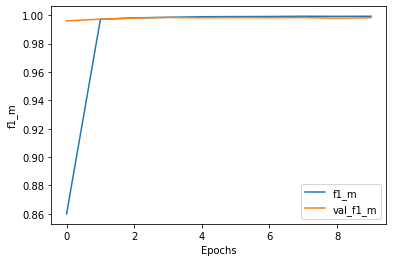

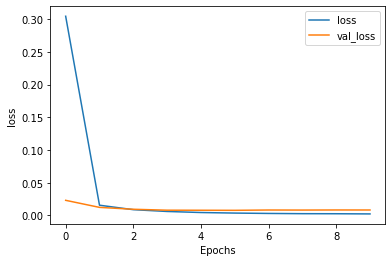

In [39]:
# plot metrics history
plot_graphs(history_4, "f1_m")
plot_graphs(history_4, "loss")

In [40]:
# save model
model_4.save('drive/MyDrive/Colab Notebooks/basiq/ann_4.h5')

In [41]:
# make predictions on test set
results_4 = predict(model_4, [text_scorecard, categories_scorecard], classes)

In [42]:
# get results
results_ANN_4 = scorecard_df.copy()
results_ANN_4 = get_results(results_4, results_ANN_4)
results_ANN_4.head()

,transaction_description,transaction_amount,transaction_account_type,description_processed,transaction_type,transaction_class,confidence,error
0,0011393060001 Transfer to Macquarie Bank - Rec...,-342.52,transaction,transfer macquarie bank receipt,credit,transfer,0.998226,0.0
1,0318352 Transfer to Jimboomba Gymnastics Club ...,-157.50,transaction,transfer jimboomba gymnastics club receipt,credit,transfer,0.997146,0.0
2,0REGENTVILLE PS 2951 Visa Purchase - Receipt 1...,-49.00,transaction,regentville visa purchase receipt regentville ...,credit,payment,0.999931,0.0
3,0TUGGERAWONG PS 4097 Visa Purchase - Receipt 1...,-20.00,transaction,tuggerawong visa purchase receipt tuggerawong ...,credit,payment,0.999931,0.0
4,1001026 Transfer to Blink Property - Receipt 6...,-710.00,transaction,transfer blink property receipt,credit,transfer,0.999997,0.0


In [43]:
# how many sure missclassified transactions
print(results_ANN_4['error'].sum().astype(int))

1


In [44]:
# class distribution
results_ANN_4['transaction_class'].value_counts()

payment            393
transfer            48
cash-withdrawal     19
bank-fee             5
refund               2
Name: transaction_class, dtype: int64

In [45]:
# sort prediction by lowest confidence
results_ANN_4.sort_values(by="confidence")

,transaction_description,transaction_amount,transaction_account_type,description_processed,transaction_type,transaction_class,confidence,error
367,rates for Leichhardt BPAY Bill Payment - Recei...,-462.6,savings,rate leichhardt bpay bill payment receipt ipsw...,credit,transfer,0.532546,0.0
47,AP#12409235 TO VODAFONE (MOBILE),-50.0,transaction,vodafone mobile,credit,payment,0.622897,0.0
154,COUNCIL RATES BPAY Bill Payment - Receipt 1569...,-70.0,transaction,council rate bpay bill payment receipt penrith...,credit,payment,0.809172,0.0
42,Andy AMEX Travel Insurance premium BPAY Bill P...,-746.0,transaction,andy amex travel insurance premium bpay bill p...,credit,transfer,0.835882,0.0
17,ABCGuilin City-Guilin City-Hold for ATM debits,-200.2,transaction,abcguilin cityguilin cityhold atm debit,credit,bank-fee,0.854845,0.0
...,...,...,...,...,...,...,...,...
49,AP#14163037 FROM I IATI Transfer from I IATI -...,14.0,savings,iati transfer iati loanpmt,debit,transfer,1.000000,0.0
32,Alcohol Internal Transfer - Receipt 413949 Sav...,500.0,transaction,alcohol internal transfer receipt saving maxim...,debit,transfer,1.000000,0.0
428,virago sold money Internal Transfer - Receipt ...,800.0,savings,virago sold money internal transfer receipt or...,debit,transfer,1.000000,0.0
51,AS Offset Savings 3 Jan Internal Transfer - Re...,1675.0,transaction,offset saving jan internal transfer receipt or...,debit,transfer,1.000000,0.0


In [46]:
# save results
results_ANN_4.to_csv("drive/MyDrive/Colab Notebooks/basiq/results_ANN_4.csv", index=False)